In [44]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import numpy as np

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import re
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from transformers import BertTokenizer, TFBertForSequenceClassification

# Data crawling

In [2]:
df = pd.read_csv(r'dataset\data-review-final.csv')
df.head()

,input_id,link,title,category,address,open_hours,popular_times,website,phone,plus_code,...,data_id,images,reservations,order_online,menu,owner,complete_address,about,user_reviews,emails
0,0fff97bc-cece-4edd-ab0d-b4ad6eb62860,NaN,Vihara Dhamma Sundara,Buddhist temple,"Jl. Ir. Juanda No.223B, Pucangsawit, Jebres, S...","{""Friday"":[""9.00 am–5.00 pm""],""Monday"":[""9.00 ...",{},NaN,(0271) 643749,"CRJX+3G Pucangsawit, Surakarta City, Central Java",...,0x2e7a16582f12c515:0x16fa374ebaeeeecd,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":"""",""source"":""""}","{""id"":""111828298465089363475"",""name"":""Vihara D...","{""borough"":""Pucangsawit, Jebres"",""street"":""Jl....","[{""id"":""accessibility"",""name"":""Accessibility"",...","[{""Name"":""Mettaxiumei"",""ProfilePicture"":""https...",NaN
1,0fff97bc-cece-4edd-ab0d-b4ad6eb62860,NaN,Tirtonadi Park,Park,"Jl. A. Yani, Gilingan, Banjarsari, Surakarta C...","{""Friday"":[""Open 24 hours""],""Monday"":[""Open 24...","{""Friday"":{""0"":33,""1"":20,""10"":5,""11"":5,""12"":6,...",NaN,NaN,"CRXC+95 Gilingan, Surakarta City, Central Java",...,0x2e7a1697336d25e1:0x9e965d10ffb23cc2,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":"""",""source"":""""}","{""id"":""104418315103655540738"",""name"":""Tirtonad...","{""borough"":""Gilingan, Banjarsari"",""street"":""Jl...","[{""id"":""accessibility"",""name"":""Accessibility"",...","[{""Name"":""M Bad."",""ProfilePicture"":""https://lh...",NaN
2,0fff97bc-cece-4edd-ab0d-b4ad6eb62860,NaN,Ngarsopuro Night Market,Night market,"Jl. Diponegoro, Keprabon, Banjarsari, Surakart...","{""Friday"":[""5.00–11.00 pm""],""Monday"":[""Closed""...",{},NaN,0838-1943-4232,"CRJC+GW Keprabon, Surakarta City, Central Java",...,0x2e7a166287cccb57:0xbba4b465bfa08dcc,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":"""",""source"":""""}","{""id"":""109298893982878160837"",""name"":""Ngarsopu...","{""borough"":""Keprabon, Banjarsari"",""street"":""Jl...","[{""id"":""service_options"",""name"":""Service optio...","[{""Name"":""Putra Satria"",""ProfilePicture"":""http...",NaN
3,0fff97bc-cece-4edd-ab0d-b4ad6eb62860,NaN,Sriwedari Park,Park,"Slamet Riyadi St No.275, Sriwedari, Laweyan, S...","{""Friday"":[""Open 24 hours""],""Monday"":[""Open 24...","{""Friday"":{""0"":5,""1"":2,""10"":9,""11"":10,""12"":10,...",NaN,NaN,"CRJ7+H5 Sriwedari, Surakarta City, Central Java",...,0x2e7a1680a93d3af1:0x7e1dfa994e59efcf,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":"""",""source"":""""}","{""id"":"""",""name"":""Sriwedari Park (Owner)"",""link...","{""borough"":""Sriwedari, Laweyan"",""street"":""Slam...","[{""id"":""accessibility"",""name"":""Accessibility"",...","[{""Name"":""Desy Natalia"",""ProfilePicture"":""http...",NaN
4,0fff97bc-cece-4edd-ab0d-b4ad6eb62860,NaN,Monument 45 Banjarsari Park,Memorial park,"CRQG+RHP Monument 45 Banjarsari Park, Setabela...","{""Friday"":[""Open 24 hours""],""Monday"":[""Open 24...","{""Friday"":{""0"":12,""1"":8,""10"":64,""11"":55,""12"":4...",http://surakarta.go.id/,NaN,NaN,...,0x2e7a168c33aa2a01:0x3c93de4d15b801f9,"[{""title"":""All"",""image"":""https://lh5.googleuse...",NaN,NaN,"{""link"":"""",""source"":""""}","{""id"":"""",""name"":""Monument 45 Banjarsari Park (...","{""borough"":""Setabelan, Banjarsari"",""street"":""C...","[{""id"":""accessibility"",""name"":""Accessibility"",...","[{""Name"":""Marsepti Ndaruwati"",""ProfilePicture""...",NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   input_id            954 non-null    object 
 1   link                0 non-null      float64
 2   title               954 non-null    object 
 3   category            953 non-null    object 
 4   address             954 non-null    object 
 5   open_hours          954 non-null    object 
 6   popular_times       954 non-null    object 
 7   website             173 non-null    object 
 8   phone               319 non-null    object 
 9   plus_code           501 non-null    object 
 10  review_count        954 non-null    int64  
 11  review_rating       954 non-null    float64
 12  reviews_per_rating  954 non-null    object 
 13  latitude            954 non-null    float64
 14  longitude           954 non-null    float64
 15  cid                 954 non-null    uint64 
 16  status  

In [4]:
df = df[['user_reviews']]
df.head()

,user_reviews
0,"[{""Name"":""Mettaxiumei"",""ProfilePicture"":""https..."
1,"[{""Name"":""M Bad."",""ProfilePicture"":""https://lh..."
2,"[{""Name"":""Putra Satria"",""ProfilePicture"":""http..."
3,"[{""Name"":""Desy Natalia"",""ProfilePicture"":""http..."
4,"[{""Name"":""Marsepti Ndaruwati"",""ProfilePicture""..."


In [5]:
df['user_reviews'].iloc[0]

'[{"Name":"Mettaxiumei","ProfilePicture":"https://lh3.googleusercontent.com/a-/ALV-UjWmViIc8Nd8oi_6vtggkwIldDHJ5tFtz0GSetaZpeDmKiHOVgjT2g=s120-c-rp-mo-ba3-br100","Rating":5,"Description":"Ikut Kathina di Vihara Dhamma sundara^^\\n\\nViharanya bagus dan pengurusnya baik dan ramah..\\nJadwal Pujabakti di Hari Minggu Jam 9.30 Pagi, Kamis Jam 7 malam.","Images":["www.google.com/local/imagery/report/?cb_client=maps_sv.tactile\\u0026image_key=!1e10!2sAF1QipPabr9-Fs7UtAlAyIVzXtpHs8XY1Jt48df6t77c"],"When":"2023-11-18"},{"Name":"bumen dhiey","ProfilePicture":"https://lh3.googleusercontent.com/a-/ALV-UjV1OrPYsyDy4jrnqOqe1vzFSF-Rzw1HvUf64--GfyHspIC79d2G=s120-c-rp-mo-ba5-br100","Rating":5,"Description":"Tempatnya nampak sepi walaupun akan ada acara, namanya juga tempat ibadah..\\nPerlu diingat agar kita saling menjaga ketertiban apalagi ini adalah rumah ibadah jangan sampai kita yg berkunjung mengganggu ibadah,,\\nMenjaga adab dan sopan santun, ketika berkunjung usahakan untuk meminta ijin jika ak

In [6]:
# extract rating and description
rating = []
description = []

for i in df['user_reviews']:
    if isinstance(i,str):
        reviews = json.loads(i)
        for review in reviews:
            rating.append(review['Rating'])
            description.append(review['Description'])
df = pd.DataFrame({'label':rating, 'text' : description})
df.head()

,label,text
0,5,Ikut Kathina di Vihara Dhamma sundara^^\n\nVih...
1,5,"Tempatnya nampak sepi walaupun akan ada acara,..."
2,5,Tempatnya bagus dan rapih. Namun saat ke sana ...
3,5,"Ini Rumah ibadah untuk Umat Budha, Tapi diperb..."
4,3,Untuk ibadah ckp kecil tp tempat luas..\nKesin...


In [7]:
# ubah labeling menjadi -1,0,1
df.replace({'label' : {1:-1, 2:-1, 3:0, 4:1, 5:1}},inplace=True)
df['label'].unique()

array([ 1,  0, -1], dtype=int64)

In [8]:
df['label'].value_counts()

label
 1    6305
 0     618
-1     286
Name: count, dtype: int64

data tidak seimbang

## Resampling imbalance data

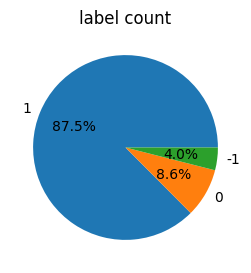

In [9]:
# sebelum di resampling
plt.figure(figsize=(6,3))
plt.pie(df['label'].value_counts(), autopct='%0.1f%%', labels=df['label'].value_counts().index)
plt.title('label count')
plt.show()

In [10]:
X = df.drop('label', axis=1)
y = df['label']

oversample = RandomOverSampler(sampling_strategy={-1:800, 0:800})
X_over, y_over = oversample.fit_resample(X,y)

undersample = RandomUnderSampler(sampling_strategy={1:800})
X_res, y_res = undersample.fit_resample(X_over,y_over)

df = pd.concat([X_res, y_res], axis=1)
df['label'].value_counts()



label
-1    800
 0    800
 1    800
Name: count, dtype: int64

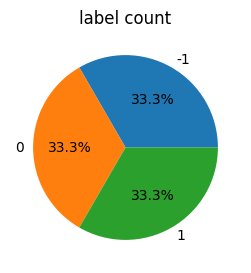

In [11]:
# setelah resampling dengan oversampling
plt.figure(figsize=(6,3))
plt.title('label count')
plt.pie(df['label'].value_counts(), autopct='%0.1f%%', labels=df['label'].value_counts().index)
plt.show()

In [12]:
# simpan file yang sudah dibalance to csv
df.to_csv(r'dataset\balance.csv', index=False)

## Cleansing data

In [13]:
df = pd.read_csv(r'dataset\balance.csv')
df.head()

,text,label
0,Fort Vastenburg ini merupakan benteng peningga...,-1
1,Kecewa berat karena jauh2 datang bersama kelua...,-1
2,Karena lokasi yg tepat di bantaran sungai jadi...,-1
3,NaN,-1
4,Reservasi nya yg retail selalu kalah dengan yg...,-1


In [14]:
df.isna().sum()

text     41
label     0
dtype: int64

In [15]:
df.dropna(inplace=True)

In [16]:
df.isna().sum()

text     0
label    0
dtype: int64

In [17]:
# inisialisasi stop words
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

# inisialisasi stemmer dari sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def clean_text(text):
    text = str(text)

    # buat text jadi huruf kecil
    text = text.lower()

    # hapus karakter non ASCII seperti karakter khusus, emot dll
    text = re.sub(r'[^\x00-\x7f]', r'', text)

    # hapus angka
    text = re.sub(r'\d+','',text)
    
    # hapus tanda baca
    text = text.translate(str.maketrans('','',string.punctuation))

    # hapus kelebihan spasi
    text = re.sub(r'\s+',' ',text).strip()

    # pisahkan text menjadi kata terpisah
    # words = text.split()

    # filter kata dari stopwords dan lakukan stemming
    # cleaned_words = []
    # for word in words:
    #     if word not in stopwords:
    #         # Melakukan stemming
    #         stemmed_word = stemmer.stem(word)
    #         # Melakukan lemmatisasi
    #         lemmatized_word = lemmatizer.lemmatize(stemmed_word, wordnet.VERB) # Anggap kata sebagai kata kerja
    #         cleaned_words.append(lemmatized_word)



    # Menggabungkan kembali kata-kata yang sudah difilter menjadi teks
    # cleaned_text = ' '.join(cleaned_words)

    return text
    

In [19]:
def remove_stopwords(text):
    word_token = word_tokenize(text)
    filtered_sentences = [w for w in word_token if w not in stopwords]
    return ' '.join(filtered_sentences)

In [20]:
def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    return text



In [21]:
df['text'][0]

'Fort Vastenburg ini merupakan benteng peninggalan penjajah Belanda yang ada di kota solo.\nBenteng ini dibangun sejak abad ke 18.\nKemarin pada saat kesana benteng ini ditutup dan tidak dapat masuk.\nSepertinya sekarang benteng ini sering sibuat untuk tempat pertunjukan konser2..\n\nBenteng ini letaknya tidak jauh dari pasar gede solo. Jalan kaki sekitar 400m saja.\n\nSayangnya sepertinya kurang terawat...\nBanyak sampah dimana2..\nSayang sekali padahal harusnya peninggalan sejarah seperti ini harus dirawat dan dijaga..'

In [22]:
# apply fungsi clean_text memakan waktu kurang lebih 30 menit

df['clean'] = df['text'].apply(preprocess_text)
df['clean'][0]

'fort vastenburg benteng peninggalan penjajah belanda kota solo benteng dibangun abad kemarin kesana benteng ditutup masuk benteng sibuat pertunjukan konser benteng letaknya pasar gede solo jalan kaki m sayangnya terawat sampah dimana sayang peninggalan sejarah dirawat dijaga'

In [23]:
df.drop('text', inplace=True, axis=1)
df.rename(columns={"clean" : "text"}, inplace=True)
df.head()

,label,text
0,-1,fort vastenburg benteng peninggalan penjajah b...
1,-1,kecewa berat keluarga air mancurnya tdk dinyal...
2,-1,lokasi yg bantaran sungai rawan hujan banjir l...
4,-1,reservasi nya yg retail kalah yg sewa menanyak...
5,-1,sorry to say yg menarik duduk kursi tingkat bu...


In [24]:
# # simpan file yang telah di cleansing
df.to_csv('dataset\preprocess.csv', index = False)

# Processing

In [25]:
df = pd.read_csv(r'dataset\preprocess.csv')
df.head()

,label,text
0,-1,fort vastenburg benteng peninggalan penjajah b...
1,-1,kecewa berat keluarga air mancurnya tdk dinyal...
2,-1,lokasi yg bantaran sungai rawan hujan banjir l...
3,-1,reservasi nya yg retail kalah yg sewa menanyak...
4,-1,sorry to say yg menarik duduk kursi tingkat bu...


In [26]:
df.isna().sum()

label    0
text     5
dtype: int64

In [27]:
df.dropna(inplace=True)

In [28]:
df.replace({'label' : {-1:0, 0:0, 1:1}},inplace=True)
df['label'].value_counts()

label
0    1566
1     788
Name: count, dtype: int64

In [29]:
X = df.drop('label', axis=1)
y = df['label']

oversample = RandomOverSampler(random_state=42)
X_over, y_over = oversample.fit_resample(X,y)

df = pd.DataFrame(X_over, columns=X.columns)
df['label'] = y_over
df.head()

,text,label
0,fort vastenburg benteng peninggalan penjajah b...,0
1,kecewa berat keluarga air mancurnya tdk dinyal...,0
2,lokasi yg bantaran sungai rawan hujan banjir l...,0
3,reservasi nya yg retail kalah yg sewa menanyak...,0
4,sorry to say yg menarik duduk kursi tingkat bu...,0


In [30]:
df['label'].value_counts()

label
0    1566
1    1566
Name: count, dtype: int64

split data menjadi train,val,test (70%, 15%, 15%)

In [31]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

df_train, df_remaining = train_test_split(df, train_size=train_ratio, random_state=42)
df_val, df_test = train_test_split(df_remaining, train_size=val_ratio/(val_ratio+test_ratio), random_state=42)

print(f"train size : {len(df_train)}")
print(f"val size : {len(df_val)}")
print(f"test size : {len(df_test)}")

train size : 2192
val size : 470
test size : 470


In [32]:
PRETRAINED_MODEL ='indobenchmark/indobert-base-p2'

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
vocab = tokenizer.get_vocab()
type(vocab)


dict

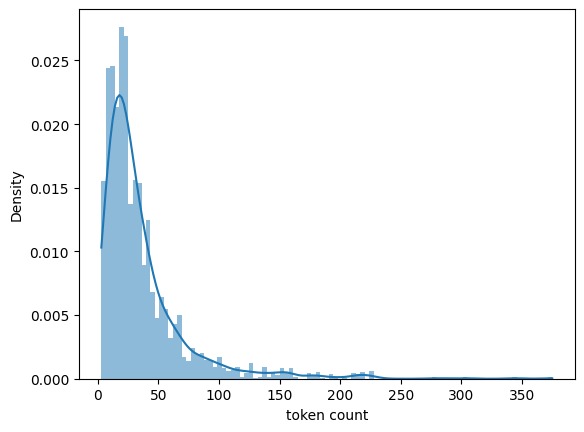

In [33]:
token_max = []

for txt in df['text']:
    tokens = tokenizer.encode(txt)
    token_max.append(len(tokens))

sns.histplot(token_max, kde=True, stat='density', linewidth=0)
plt.xlabel("token count")
plt.show()

In [34]:
MAXLEN = 250

In [35]:
def encode_sentence(sent):
    return tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        padding='max_length',
        truncation='longest_first',
        max_length=MAXLEN,
        return_attention_mask=True,
        return_token_type_ids=True
    )

In [36]:
def map_example_to_dict(input_ids, attention_mask, token_type_ids, label):
    return {
        'input_ids' : input_ids,
        'attention_mask' : attention_mask,
        'token_type_ids' : token_type_ids,
    }, label

In [37]:
def encode_dataset(ds, limit = -1):
    input_ids_list = []
    attention_mask_list = []
    token_type_ids_list = []
    label_list = []

    for index, row in ds.iterrows():
        if limit > 0 and index >= limit:
            break

        input_ids, attention_mask, token_type_ids = \
        encode_sentence(row['text'])['input_ids'],\
        encode_sentence(row['text'])['attention_mask'], \
        encode_sentence(row['text'])['token_type_ids']

        label = row['label']

        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        token_type_ids_list.append(token_type_ids)
        label_list.append(label)
    
    return tf.data.Dataset.from_tensor_slices((
        input_ids_list,
        attention_mask_list,
        token_type_ids_list,
        label_list
    )).map(map_example_to_dict)

In [38]:
EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 5e-5

train_data = encode_dataset(df_train).shuffle(100).batch(BATCH_SIZE)
val_data = encode_dataset(df_val).batch(BATCH_SIZE)
test_data = encode_dataset(df_test).batch(BATCH_SIZE)

In [39]:
model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=3)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  124441344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 124,443,651
Trainable params: 124,443,651
Non-trainable params: 0
_________________________________________________________________


In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [41]:
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data)

Epoch 1/5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


274/274 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.7144

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


274/274 [==============================] - 120s 350ms/step - loss: 0.5748 - accuracy: 0.7144 - val_loss: 0.4444 - val_accuracy: 0.7936
Epoch 2/5
274/274 [==============================] - 93s 339ms/step - loss: 0.3428 - accuracy: 0.8682 - val_loss: 0.4473 - val_accuracy: 0.8426
Epoch 3/5
274/274 [==============================] - 94s 342ms/step - loss: 0.1682 - accuracy: 0.9448 - val_loss: 0.3827 - val_accuracy: 0.8851
Epoch 4/5
274/274 [==============================] - 93s 341ms/step - loss: 0.1064 - accuracy: 0.9685 - val_loss: 0.5000 - val_accuracy: 0.8745
Epoch 5/5
274/274 [==============================] - 93s 341ms/step - loss: 0.1065 - accuracy: 0.9726 - val_loss: 0.5389 - val_accuracy: 0.8447


In [43]:
y_pred = model.predict(test_data)
y_actual = np.concatenate([y for x, y in test_data], axis=0)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


59/59 [==============================] - 11s 116ms/step


In [45]:
accuracy_score(y_actual, np.argmax(y_pred[0], axis=1))

0.8553191489361702

<Axes: >

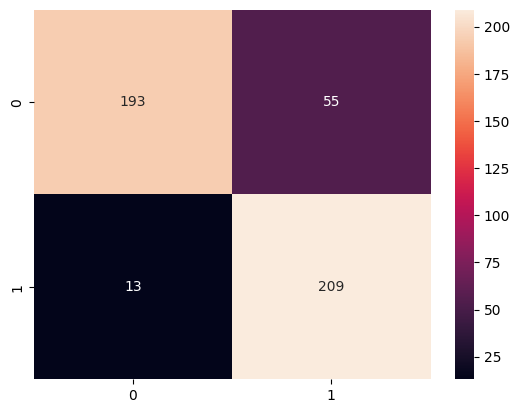

In [46]:
cm = confusion_matrix(y_actual, np.argmax(y_pred[0], axis = 1))
sns.heatmap(cm, annot=True, fmt='d')

In [47]:
print(classification_report(y_actual, np.argmax(y_pred[0], axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       248
           1       0.79      0.94      0.86       222

    accuracy                           0.86       470
   macro avg       0.86      0.86      0.86       470
weighted avg       0.87      0.86      0.85       470

